In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import partial_corr
import corr_significance

Lab 2:
Ниже представлено то, что уже сделано.
Что ещё нужно сделать:
- порисовать гистограммы, в т.ч. для признака $State$
- сформулировать задачу регрессии после отбора, анализа и преобразования признаков
- оценить качество регрессии (множественный коэффициент корреляции, распределение остатков, мультиколлинеарность.

Также из Lab 1 нужны результаты о распределениях некоторых из признаков (и по возможности идеи, как их преобразовать, чтобы было что-то похожее хотя бы на нормальное распределение)

In [2]:
roads = pd.read_csv('fulldata.csv')
roads.head()

Unnamed: 0     lat_     lon_  State_  Ta_mean  Ta_min  Ta_max  Tsurf_mean  \
0           0  68.0926  16.3644       3     14.1    14.1    14.1    1.675000   
1           1  68.0926  16.3645       3     14.1    14.1    14.1    1.787778   
2           2  68.0926  16.3646       3     14.1    14.1    14.1    2.050000   
3           3  68.0926  16.3647       3     14.1    14.1    14.1    1.920000   
4           4  68.0926  16.3648       3     14.1    14.1    14.1    1.550000   

   Tsurf_min  Tsurf_max  ...  WindGustKmph  cloudcover  humidity  precipMM  \
0       1.61       1.74  ...            36          63        69       0.0   
1       1.55       1.98  ...            36          63        69       0.0   
2       2.05       2.05  ...            36          63        69       0.0   
3       1.92       1.92  ...            36          63        69       0.0   
4       1.55       1.55  ...            36          63        69       0.0   

   pressure  tempC  visibility  winddirDegree  windspeedKmph  location  
0      1000     -5          10            152             17  kjopsvik  
1      1000     -5          10            152             17  kjopsvik  
2      1000     -5          10            152             17  kjopsvik  
3      1000     -5          10            152             17  kjopsvik  
4      1000     -5          10            152             17  kjopsvik  

[5 rows x 56 columns]

Взгляд на данные

In [3]:
roads.describe()

Unnamed: 0           lat_           lon_         State_  \
count  196133.000000  196133.000000  196133.000000  196133.000000   
mean    98066.000000      68.441392      17.404080       3.913166   
std     56618.864511       0.075406       0.222358       1.629454   
min         0.000000      68.092600      16.261200       1.000000   
25%     49033.000000      68.421000      17.398700       3.000000   
50%     98066.000000      68.439900      17.435100       4.000000   
75%    147099.000000      68.452800      17.504700       5.000000   
max    196132.000000      68.579900      17.756000       6.000000   

             Ta_mean         Ta_min         Ta_max     Tsurf_mean  \
count  196133.000000  196133.000000  196133.000000  196133.000000   
mean        5.825165       4.155892       7.482814      -2.894245   
std         4.903184       5.778461       5.060864       4.511800   
min       -10.100000     -10.100000     -10.100000     -15.500000   
25%         2.100000      -0.600000       4.500000      -6.466000   
50%         6.300000       4.400000       8.100000      -1.913571   
75%         9.400000       8.600000      11.000000       0.848000   
max        19.631818      19.500000      19.700000      15.751304   

           Tsurf_min      Tsurf_max  ...     WindChillC   WindGustKmph  \
count  196133.000000  196133.000000  ...  196133.000000  196133.000000   
mean       -4.462499      -1.407239  ...      -8.972437      20.415310   
std         5.345610       4.497291  ...       5.988953       9.714054   
min       -17.550000     -15.500000  ...     -25.000000       3.000000   
25%        -9.650000      -3.840000  ...     -13.000000      14.000000   
50%        -3.640000       0.070000  ...      -8.000000      19.000000   
75%         0.420000       1.760000  ...      -4.000000      26.000000   
max        15.480000      16.410000  ...       3.000000      79.000000   

          cloudcover       humidity       precipMM       pressure  \
count  196133.000000  196133.000000  196133.000000  196133.000000   
mean       61.094038      77.866091       0.161564    1011.298247   
std        32.748816      11.343793       0.412834       8.989362   
min         0.000000      32.000000       0.000000     990.000000   
25%        29.000000      72.000000       0.000000    1005.000000   
50%        68.000000      77.000000       0.000000    1010.000000   
75%        92.000000      85.000000       0.100000    1018.000000   
max       100.000000     100.000000       5.200000    1030.000000   

               tempC     visibility  winddirDegree  windspeedKmph  
count  196133.000000  196133.000000  196133.000000  196133.000000  
mean       -4.445932       8.345256     147.220549      12.466795  
std         4.609787       2.861586      50.219103       5.555945  
min       -19.000000       0.000000      85.000000       2.000000  
25%        -8.000000       7.000000     107.000000       9.000000  
50%        -4.000000      10.000000     139.000000      12.000000  
75%        -1.000000      10.000000     161.000000      15.000000  
max         6.000000      10.000000     312.000000      40.000000  

[8 rows x 46 columns]

Здесь отбираем выборку в 1000 наблюдений по признакам, перечисленным в ячейке.
- Вопрос: возможно, здесь стоит отобрать выборку стратифицированно по $State$
- Выбор признаков не окончательный: всё зависит от результатов проверок гипотез, но предсказывать будем Friction как меру риска ДТП

In [4]:
np.random.seed(42)
sample = roads[['State_', 'Ta_mean', 'Tsurf_mean', 'Water_mean', 'Speed_mean', 'Height_mean', 'Friction_mean', 'mintempC', 'DewPointC', 'humidity', 'pressure']].sample(1000)

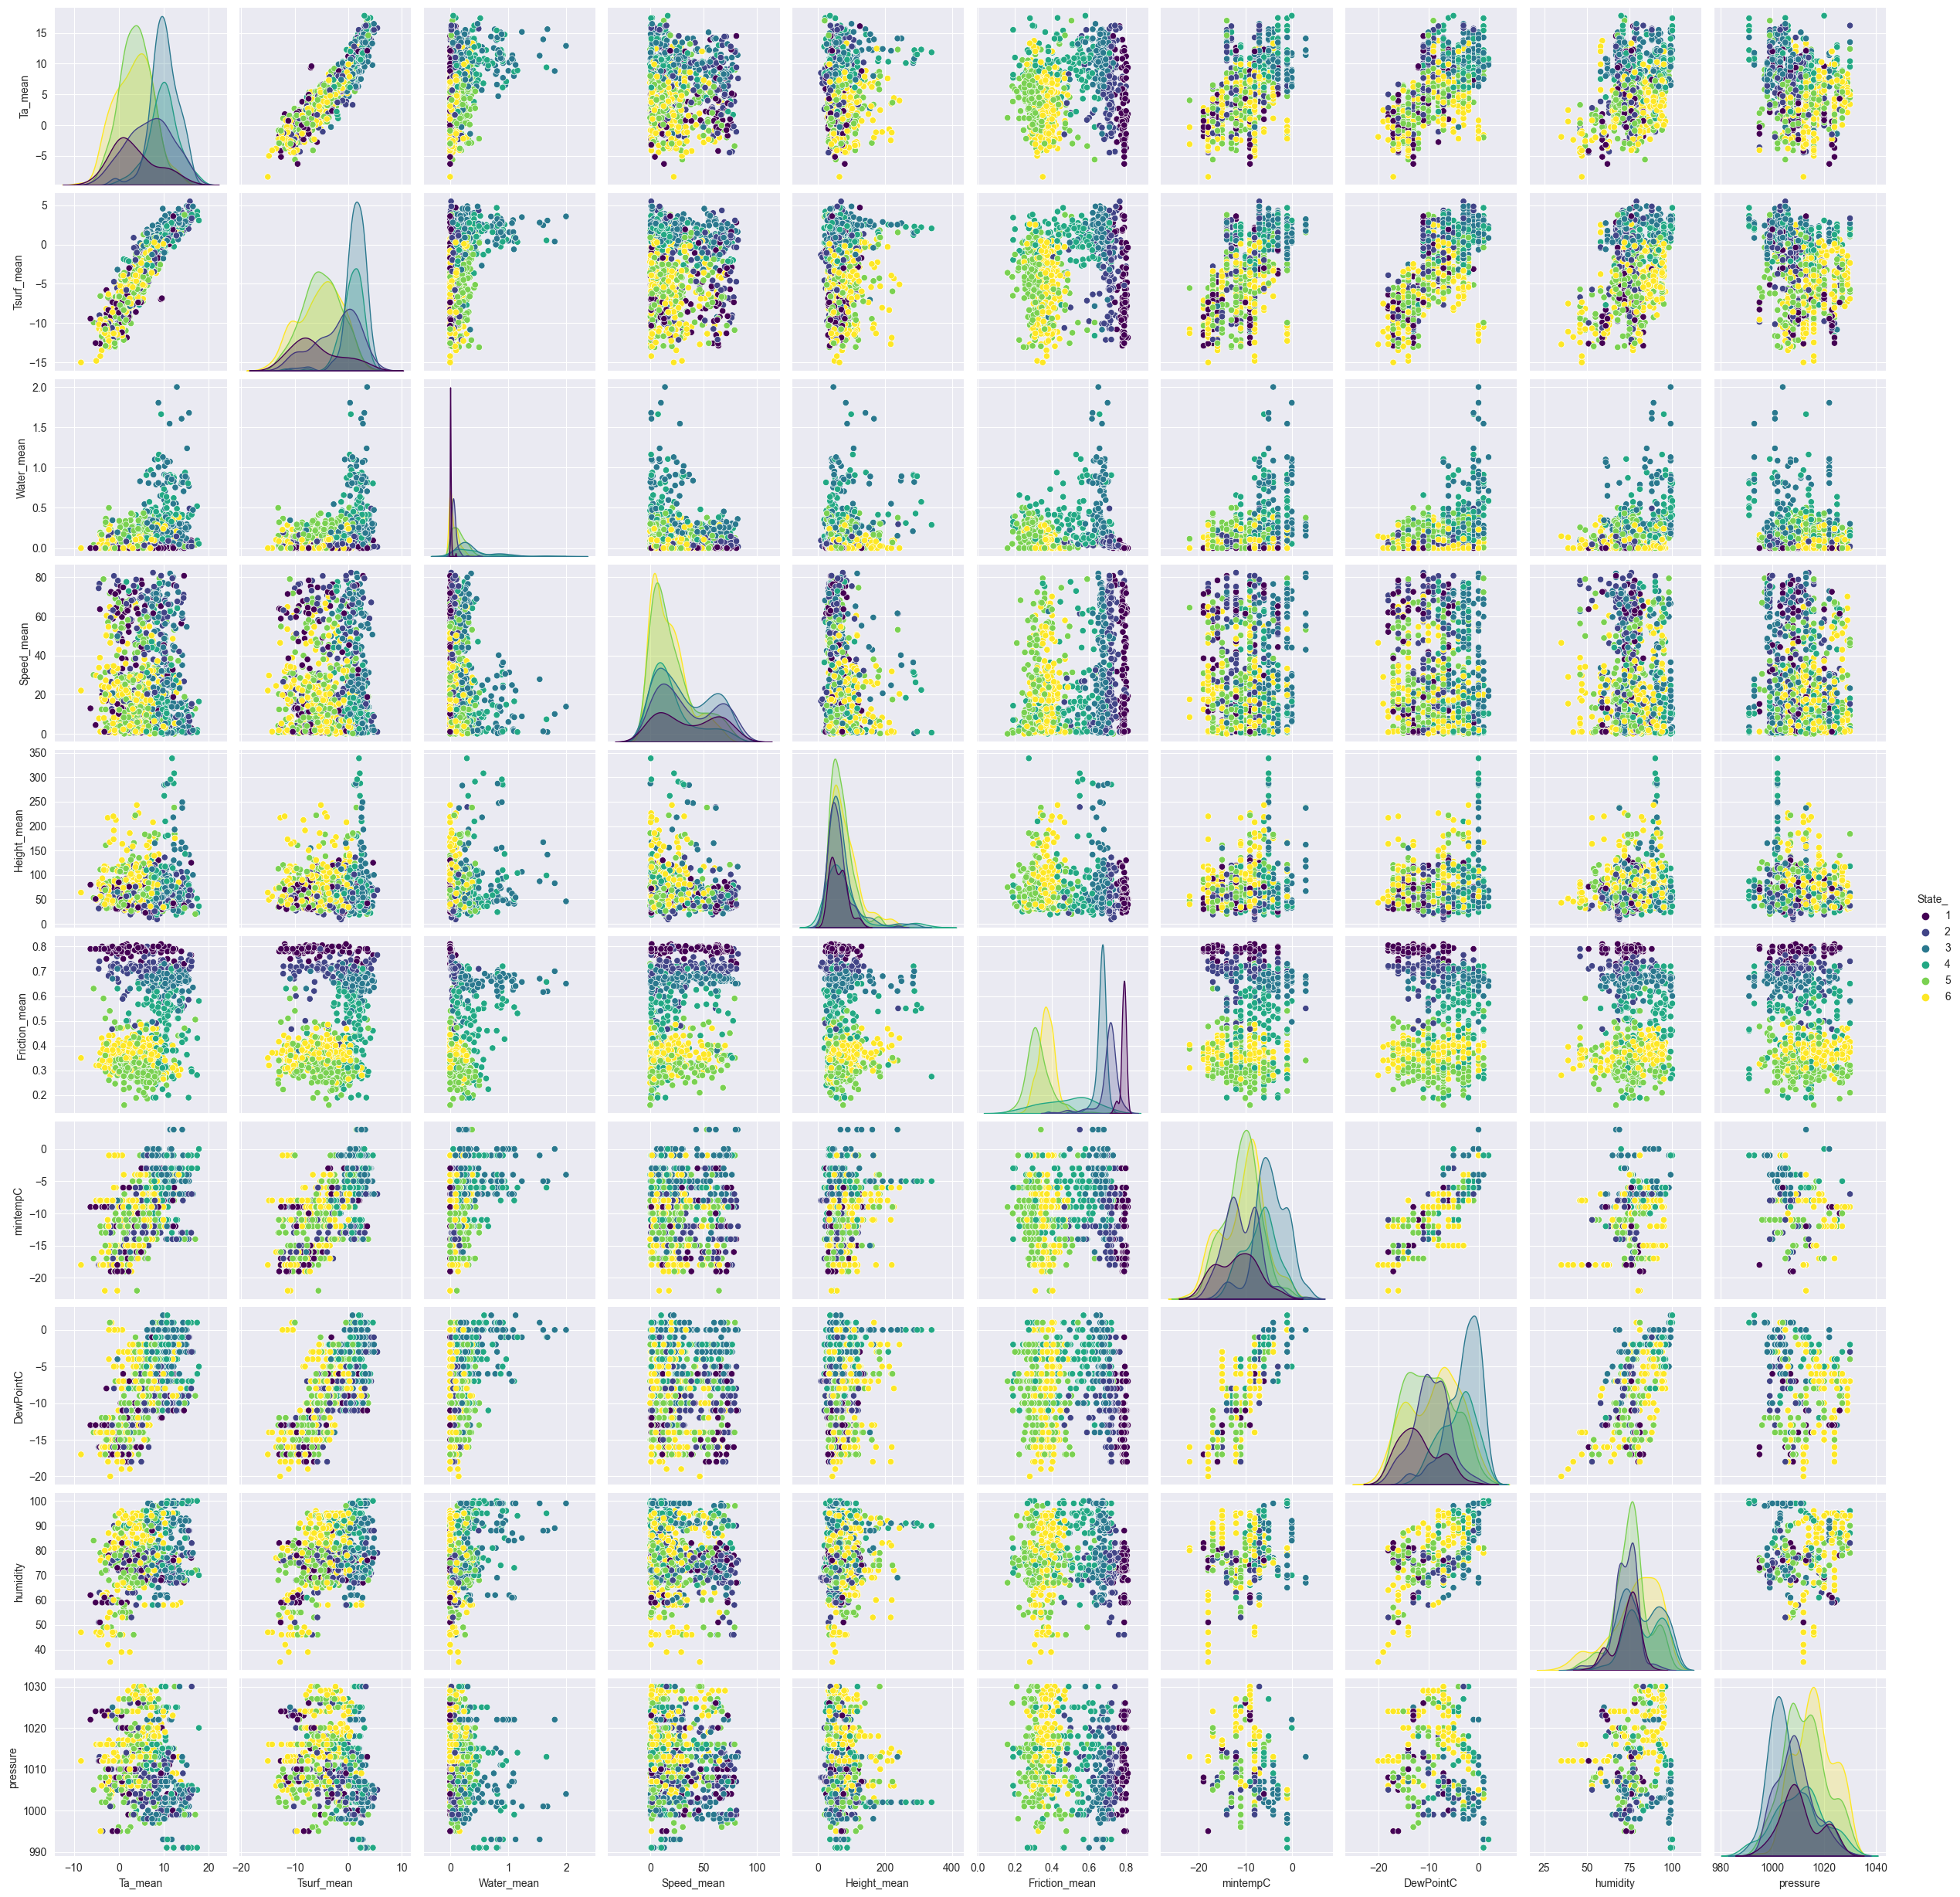

In [5]:
sns.pairplot(data = sample, hue='State_', palette='viridis')

Методом пристального взгляда в признаке Friction видна бимодальность, разбиваемая по State

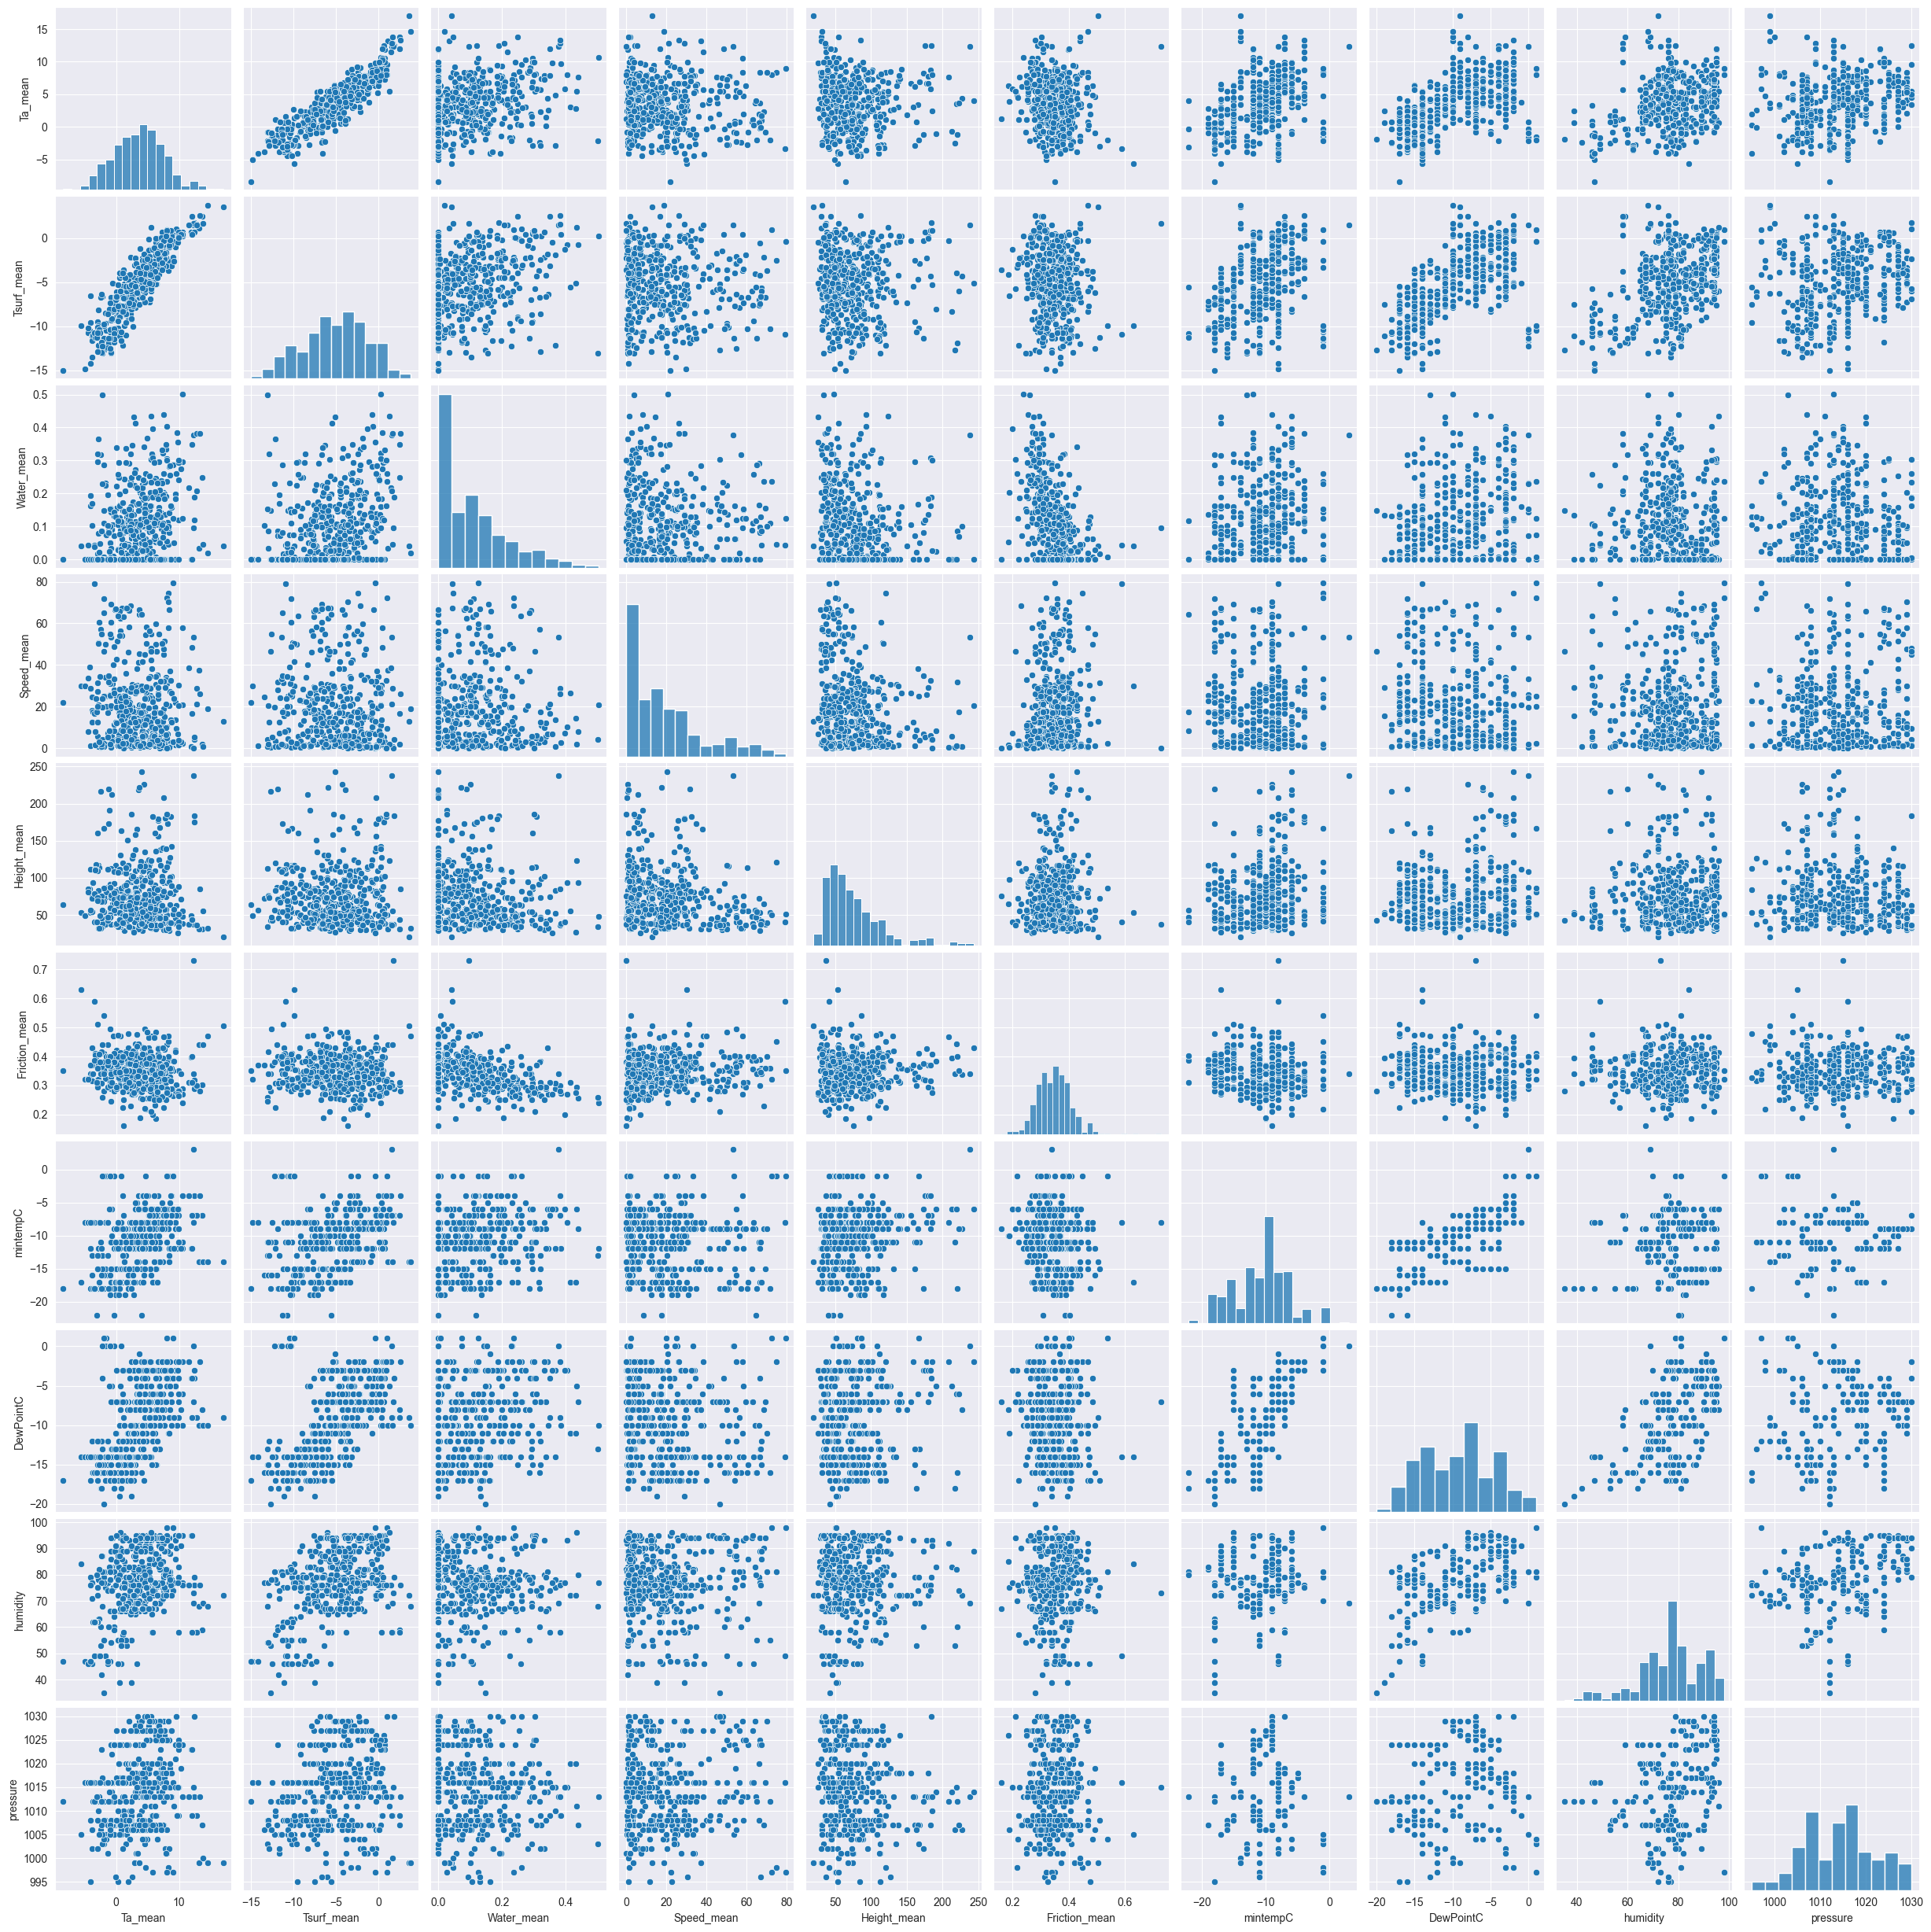

In [6]:
sns.pairplot(data = sample[sample['State_'] > 4].iloc[:,1:])

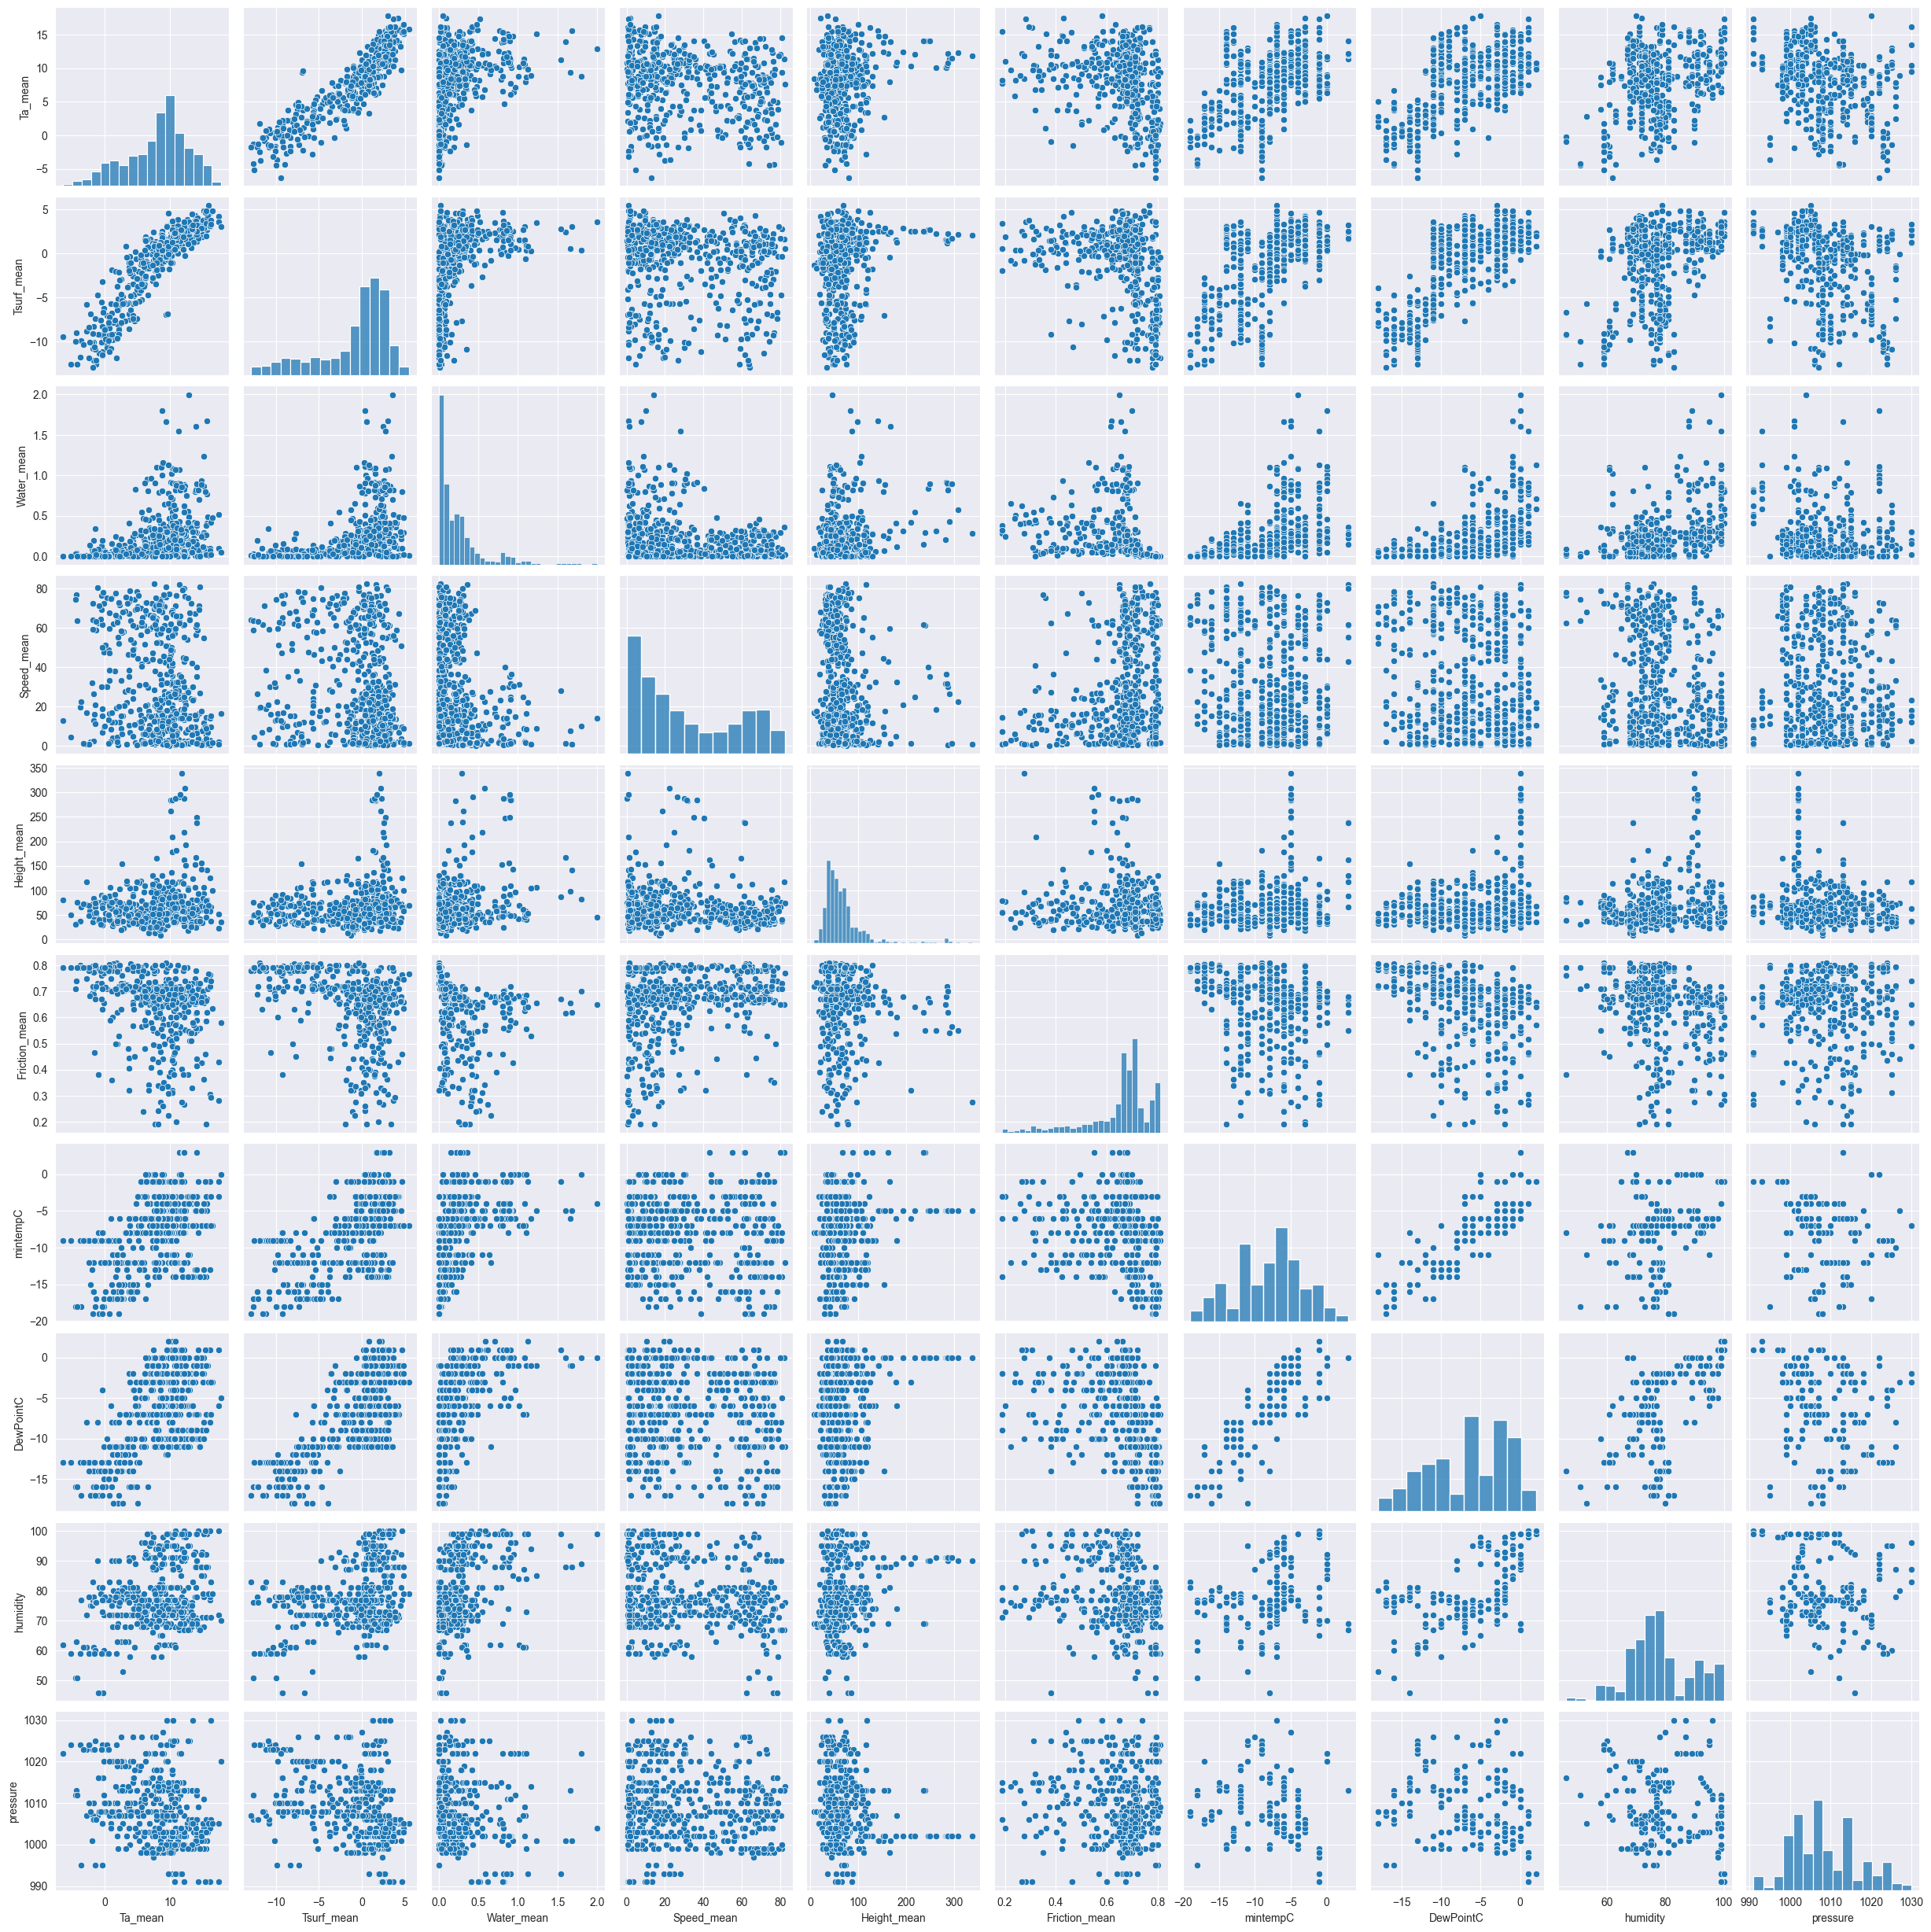

In [7]:
sns.pairplot(data = sample[sample['State_'] <= 4].iloc[:,1:])

Это разбиение нужно обсудить.
Также нужно попробовать различные преобразования над некоторыми признаками с несимметричными распределениями. (по-хорошему нужно получить для некоторых (всех) из признаков нормальность, так как дальнейшее построение регрессии завязано на этом (гауссовская регрессия линейна!)

Предсказывать будем $Friction$ (как показатель риска аварий) по
- $Tsurf$ - температура поверхности
- $Water$ - толщина водяного слоя
- $Speed$ - скорость ветра
- $Height$ - высота над уровнем моря
- $mintempC$ - минимальная температура в регионе (нужно уточить)
- $DewPointC$ - точка росы
- $humidity$ - влажность
- $pressure$ - атмосферное давление
- $State$ - словесное описание состояния поверхности дороги

После рассмотрения PairPlot'a можно увидеть, что Friction довольно бимодальна и это объяснимо показателем State: можно разбить данные по $State > 4$ и $State \le 4$

Здесь мы просто смотрим векторы средних и ковариационные матрицы после разбиения.

In [8]:
samplel4, sampleb4 = sample[sample['State_'] <= 4], sample[sample['State_'] > 4]

In [9]:
samplel4.mean()

State_              2.630394
Ta_mean             8.040291
Tsurf_mean         -0.928271
Water_mean          0.241741
Speed_mean         30.808533
Height_mean        67.441853
Friction_mean       0.653023
mintempC           -8.000000
DewPointC          -6.517824
humidity           78.135084
pressure         1008.647280
dtype: float64

In [10]:
sampleb4.mean()

State_              5.496788
Ta_mean             3.627040
Tsurf_mean         -5.102501
Water_mean          0.107762
Speed_mean         19.256158
Height_mean        75.472420
Friction_mean       0.348648
mintempC          -10.584582
DewPointC          -9.207709
humidity           76.884368
pressure         1014.366167
dtype: float64

In [11]:
samplel4.cov()

State_    Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
State_         1.007871   2.242742    2.300470    0.147807   -4.907852   
Ta_mean        2.242742  22.183832   17.786179    0.524070  -25.172482   
Tsurf_mean     2.300470  17.786179   17.386652    0.508091  -15.340217   
Water_mean     0.147807   0.524070    0.508091    0.091978   -2.104341   
Speed_mean    -4.907852 -25.172482  -15.340217   -2.104341  657.074942   
Height_mean    7.078665  31.463302   25.939993    3.649775 -175.023286   
Friction_mean -0.094636  -0.186309   -0.171939   -0.010421    0.881695   
mintempC       2.253759   9.767126   10.937211    0.656102   -3.751041   
DewPointC      3.073287  14.755953   15.600008    0.847332  -19.255372   
humidity       4.416563  16.098619   17.738690    1.478630  -51.119810   
pressure      -0.273470 -12.292297  -10.886234   -0.355130  -10.437057   

               Height_mean  Friction_mean   mintempC  DewPointC    humidity  \
State_            7.078665      -0.094636   2.253759   3.073287    4.416563   
Ta_mean          31.463302      -0.186309   9.767126  14.755953   16.098619   
Tsurf_mean       25.939993      -0.171939  10.937211  15.600008   17.738690   
Water_mean        3.649775      -0.010421   0.656102   0.847332    1.478630   
Speed_mean     -175.023286       0.881695  -3.751041 -19.255372  -51.119810   
Height_mean    2095.811295      -0.478875  30.946966  54.729255   98.280057   
Friction_mean    -0.478875       0.015713  -0.144316  -0.206002   -0.313315   
mintempC         30.946966      -0.144316  22.597744  19.383459   13.028195   
DewPointC        54.729255      -0.206002  19.383459  25.032107   30.788127   
humidity         98.280057      -0.313315  13.028195  30.788127  116.865177   
pressure        -52.983990      -0.031559  -6.812030  -7.991261  -10.978579   

                pressure  
State_         -0.273470  
Ta_mean       -12.292297  
Tsurf_mean    -10.886234  
Water_mean     -0.355130  
Speed_mean    -10.437057  
Height_mean   -52.983990  
Friction_mean  -0.031559  
mintempC       -6.812030  
DewPointC      -7.991261  
humidity      -10.978579  
pressure       66.435505

In [12]:
sampleb4.cov()

State_    Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
State_         0.250526  -0.142452   -0.075373   -0.021377   -0.655770   
Ta_mean       -0.142452  15.467560   13.316978    0.107814   -7.119192   
Tsurf_mean    -0.075373  13.316978   14.199366    0.106181   -6.001315   
Water_mean    -0.021377   0.107814    0.106181    0.011967   -0.044412   
Speed_mean    -0.655770  -7.119192   -6.001315   -0.044412  347.866474   
Height_mean    2.395898  -2.201709    0.728254   -0.446073 -122.547453   
Friction_mean  0.009500  -0.024550   -0.020372   -0.003073    0.105685   
mintempC       0.048547   6.045008    5.895518    0.077629   -3.873258   
DewPointC      0.204267   9.642071   10.619324    0.087656  -10.014057   
humidity       0.536108  16.388342   19.550981   -0.056334    0.086073   
pressure       0.931436   5.406327    6.402062   -0.095670    3.613477   

               Height_mean  Friction_mean   mintempC  DewPointC    humidity  \
State_            2.395898       0.009500   0.048547   0.204267    0.536108   
Ta_mean          -2.201709      -0.024550   6.045008   9.642071   16.388342   
Tsurf_mean        0.728254      -0.020372   5.895518  10.619324   19.550981   
Water_mean       -0.446073      -0.003073   0.077629   0.087656   -0.056334   
Speed_mean     -122.547453       0.105685  -3.873258 -10.014057    0.086073   
Height_mean    1578.341108       0.122289  26.034658  17.147507    7.273116   
Friction_mean     0.122289       0.003869  -0.021014  -0.014400    0.028886   
mintempC         26.034658      -0.021014  17.977273  14.668016    4.694061   
DewPointC        17.147507      -0.014400  14.668016  23.847322   31.265630   
humidity          7.273116       0.028886   4.694061  31.265630  152.351407   
pressure        -43.322533       0.020498   0.448420   4.441026   29.010243   

                pressure  
State_          0.931436  
Ta_mean         5.406327  
Tsurf_mean      6.402062  
Water_mean     -0.095670  
Speed_mean      3.613477  
Height_mean   -43.322533  
Friction_mean   0.020498  
mintempC        0.448420  
DewPointC       4.441026  
humidity       29.010243  
pressure       64.395677

Условные распределения Friction при условии State

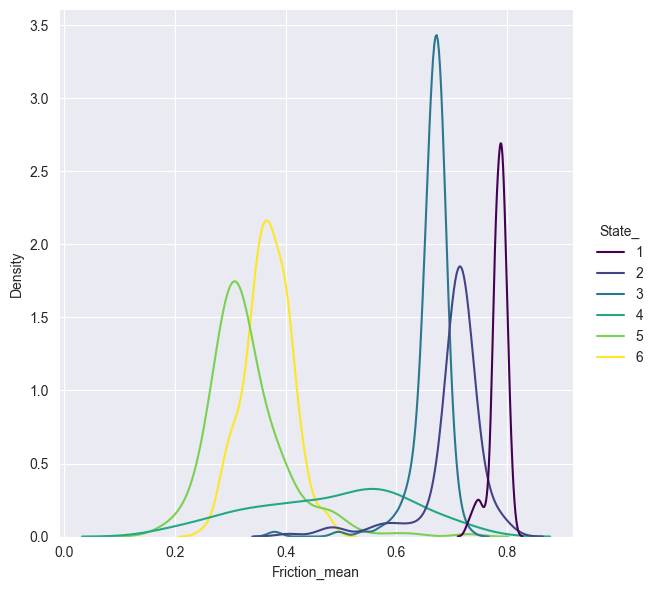

In [13]:
sns.displot(
    data=sample,
    x="Friction_mean", hue='State_',
    kind="kde", height=6,
    palette="viridis",
)

Условные распределения Friction при условии humidity: здесь дискретизация по квантилям (для того, чтобы подвыборки были не самые малые в каждой группе)

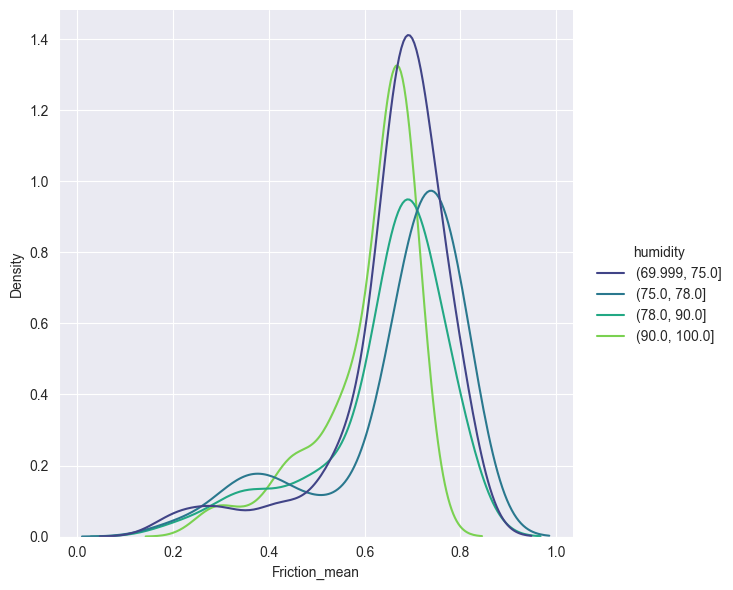

In [14]:
sns.displot(
    x=samplel4["Friction_mean"], hue=pd.qcut(samplel4['humidity'], q = [0.2, 0.4, 0.6, 0.8, 1]),
    kind="kde", height=6,
    palette="viridis",
)

Условные распределения Friction при условии Water: здесь дискретизация по квантилям (для того, чтобы подвыборки были не самые малые в каждой группе)

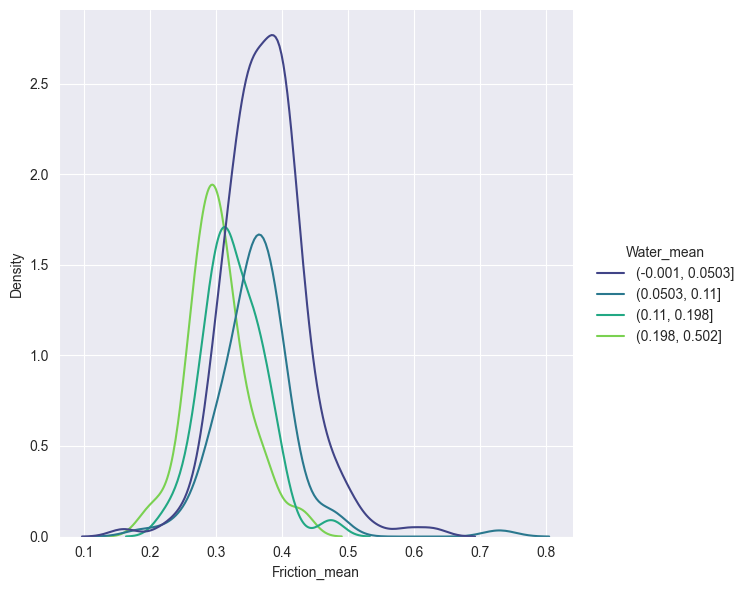

In [15]:
sns.displot(
    x=sampleb4["Friction_mean"], hue=pd.qcut(sampleb4['Water_mean'], q = [0.2, 0.4, 0.6, 0.8, 1]),
    kind="kde", height=6,
    palette="viridis",
)

Корреляционная матрица по выборке с $State \le 4$

In [16]:
samplel4.corr()

State_   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
State_         1.000000  0.474306    0.549549    0.485456   -0.190713   
Ta_mean        0.474306  1.000000    0.905642    0.366884   -0.208497   
Tsurf_mean     0.549549  0.905642    1.000000    0.401783   -0.143521   
Water_mean     0.485456  0.366884    0.401783    1.000000   -0.270686   
Speed_mean    -0.190713 -0.208497   -0.143521   -0.270686    1.000000   
Height_mean    0.154018  0.145918    0.135889    0.262874   -0.149146   
Friction_mean -0.751998 -0.315559   -0.328951   -0.274111    0.274395   
mintempC       0.472251  0.436230    0.551780    0.455089   -0.030783   
DewPointC      0.611860  0.626182    0.747770    0.558422   -0.150140   
humidity       0.406948  0.316175    0.393524    0.450998   -0.184476   
pressure      -0.033420 -0.320195   -0.320309   -0.143663   -0.049954   

               Height_mean  Friction_mean  mintempC  DewPointC  humidity  \
State_            0.154018      -0.751998  0.472251   0.611860  0.406948   
Ta_mean           0.145918      -0.315559  0.436230   0.626182  0.316175   
Tsurf_mean        0.135889      -0.328951  0.551780   0.747770  0.393524   
Water_mean        0.262874      -0.274111  0.455089   0.558422  0.450998   
Speed_mean       -0.149146       0.274395 -0.030783  -0.150140 -0.184476   
Height_mean       1.000000      -0.083447  0.142203   0.238943  0.198585   
Friction_mean    -0.083447       1.000000 -0.242185  -0.328464 -0.231209   
mintempC          0.142203      -0.242185  1.000000   0.814986  0.253518   
DewPointC         0.238943      -0.328464  0.814986   1.000000  0.569236   
humidity          0.198585      -0.231209  0.253518   0.569236  1.000000   
pressure         -0.141993      -0.030887 -0.175810  -0.195960 -0.124596   

               pressure  
State_        -0.033420  
Ta_mean       -0.320195  
Tsurf_mean    -0.320309  
Water_mean    -0.143663  
Speed_mean    -0.049954  
Height_mean   -0.141993  
Friction_mean -0.030887  
mintempC      -0.175810  
DewPointC     -0.195960  
humidity      -0.124596  
pressure       1.000000

Значимость корреляции:
Пусть $\hat{\rho}_n$ --- оценка $\rho = \rho(\xi, \eta)$ по выборке, $(\xi, \eta)^T \sim N(\mu, \Sigma)$.
Проверяем гипотезу $H_0: \rho = 0$.
Статистика: $$ t = \sqrt{n-2}\frac{\hat{\rho}_n}{\sqrt{1-\hat{\rho}^2_n}} \sim t(n-2) $$
После $z$-преобразования:
$$ z = \frac{1}{2} \ln \frac{1+\hat\rho_n}{1-\hat\rho_n},\ z_0 = \frac{1}{2} \ln \frac{1+\rho_0}{1-\rho_0} $$
его можно привести к виду:
$$ \sqrt{n-3}(z-z_0) \to^d N(0, 1) $$

Результаты применения критерия проверки значимости корреляции Friction с остальными признаками для этой группы наблюдений. Здесь слева направо даны коэффициент корреляции, левая и правая границы доверительного интервала для коэф. корреляции и p-value; гипотеза проверялась на уровне значимости $\alpha = 0.05$. Важно! этот критерий валиден в случае нормальных данных (https://online.stat.psu.edu/stat501/lesson/1/1.9) или тогда, когда линейная связь оправдана.

In [25]:
corr_res_l4 = corr_significance.multiple_corr_test(samplel4, pivot = 'Friction_mean',
                                     regressors=['Tsurf_mean', 'Water_mean', 'Speed_mean', 'Height_mean', 'mintempC', 'DewPointC', 'humidity', 'pressure'])
corr_res_l4

$\rho$      left     right       p-value
Tsurf_mean  -0.328951 -0.426787 -0.256517  6.462881e-15
Water_mean  -0.274111 -0.366438 -0.196168  1.217172e-10
Speed_mean   0.274395  0.196475  0.366746  1.162697e-10
Height_mean -0.083447 -0.168777  0.001494  5.418419e-02
mintempC    -0.242185 -0.332229 -0.161959  1.490423e-08
DewPointC   -0.328464 -0.426240 -0.255970  7.120559e-15
humidity    -0.231209 -0.320601 -0.150331  6.714241e-08
pressure    -0.030887 -0.116033  0.054238  4.767203e-01

Частная корреляция (partial correlation)
$$ \rho(\xi, \eta \mid \alpha_1, \dots, \alpha_n) = \rho(\xi - \widetilde{\xi}, \eta - \widetilde{\eta}) $$
$$ \widetilde{\xi} = \arg \min_{\xi^* \in K} \mathbf{E} (\xi - \xi^*)^2 $$
$$ \widetilde{\eta} = \arg \min_{\eta^* \in K} \mathbf{E} (\eta - \eta^*)^2 $$
$$ K = \{a_0 + a_1 \alpha_1 + \dots + a_n \alpha_n\} $$

In [18]:
partial_corr.par_corr(samplel4.drop(columns=['State_']))

Ta_mean  Tsurf_mean  Water_mean  Speed_mean  Height_mean  \
Ta_mean        1.000000    0.823211    0.055084   -0.173636     0.052023   
Tsurf_mean     0.823211    1.000000   -0.055838    0.122971    -0.107039   
Water_mean     0.055084   -0.055838    1.000000   -0.182396     0.127402   
Speed_mean    -0.173636    0.122971   -0.182396    1.000000    -0.076387   
Height_mean    0.052023   -0.107039    0.127402   -0.076387     1.000000   
Friction_mean -0.035780   -0.063023   -0.068176    0.192746     0.007956   
mintempC      -0.082605   -0.053372    0.130121    0.103066    -0.091009   
DewPointC     -0.043811    0.358135    0.098140   -0.037980     0.152297   
humidity      -0.097636   -0.008035    0.203171   -0.028329    -0.008562   
pressure      -0.087763   -0.104423   -0.045038   -0.098240    -0.126384   

               Friction_mean  mintempC  DewPointC  humidity  pressure  
Ta_mean            -0.035780 -0.082605  -0.043811 -0.097636 -0.087763  
Tsurf_mean         -0.063023 -0.053372   0.358135 -0.008035 -0.104423  
Water_mean         -0.068176  0.130121   0.098140  0.203171 -0.045038  
Speed_mean          0.192746  0.103066  -0.037980 -0.028329 -0.098240  
Height_mean         0.007956 -0.091009   0.152297 -0.008562 -0.126384  
Friction_mean       1.000000 -0.034775  -0.010919 -0.045173 -0.135483  
mintempC           -0.034775  1.000000   0.763844 -0.465364 -0.101138  
DewPointC          -0.010919  0.763844   1.000000  0.547162  0.132546  
humidity           -0.045173 -0.465364   0.547162  1.000000 -0.080390  
pressure           -0.135483 -0.101138   0.132546 -0.080390  1.000000

Всё аналогичное для остальной группы наблюдений

In [19]:
sampleb4.corr()

State_   Ta_mean  Tsurf_mean  Water_mean  Speed_mean  \
State_         1.000000 -0.072366   -0.039963   -0.390416   -0.070246   
Ta_mean       -0.072366  1.000000    0.898587    0.250599   -0.097054   
Tsurf_mean    -0.039963  0.898587    1.000000    0.257587   -0.085390   
Water_mean    -0.390416  0.250599    0.257587    1.000000   -0.021767   
Speed_mean    -0.070246 -0.097054   -0.085390   -0.021767    1.000000   
Height_mean    0.120487 -0.014091    0.004865   -0.102640   -0.165386   
Friction_mean  0.305118 -0.100352   -0.086914   -0.451652    0.091095   
mintempC       0.022876  0.362513    0.368999    0.167369   -0.048979   
DewPointC      0.083570  0.502041    0.577089    0.164087   -0.109947   
humidity       0.086777  0.337599    0.420350   -0.041722    0.000374   
pressure       0.231899  0.171302    0.211718   -0.108983    0.024143   

               Height_mean  Friction_mean  mintempC  DewPointC  humidity  \
State_            0.120487       0.305118  0.022876   0.083570  0.086777   
Ta_mean          -0.014091      -0.100352  0.362513   0.502041  0.337599   
Tsurf_mean        0.004865      -0.086914  0.368999   0.577089  0.420350   
Water_mean       -0.102640      -0.451652  0.167369   0.164087 -0.041722   
Speed_mean       -0.165386       0.091095 -0.048979  -0.109947  0.000374   
Height_mean       1.000000       0.049485  0.154557   0.088385  0.014832   
Friction_mean     0.049485       1.000000 -0.079677  -0.047407  0.037623   
mintempC          0.154557      -0.079677  1.000000   0.708418  0.089694   
DewPointC         0.088385      -0.047407  0.708418   1.000000  0.518709   
humidity          0.014832       0.037623  0.089694   0.518709  1.000000   
pressure         -0.135889       0.041066  0.013179   0.113327  0.292887   

               pressure  
State_         0.231899  
Ta_mean        0.171302  
Tsurf_mean     0.211718  
Water_mean    -0.108983  
Speed_mean     0.024143  
Height_mean   -0.135889  
Friction_mean  0.041066  
mintempC       0.013179  
DewPointC      0.113327  
humidity       0.292887  
pressure       1.000000

In [26]:
corr_res_b4 = corr_significance.multiple_corr_test(sampleb4, pivot = 'Friction_mean',
                                     regressors=['Tsurf_mean', 'Water_mean', 'Speed_mean', 'Height_mean', 'mintempC', 'DewPointC', 'humidity', 'pressure'])
corr_res_b4

$\rho$      left     right       p-value
Tsurf_mean  -0.086914 -0.178123  0.003855  6.055355e-02
Water_mean  -0.451652 -0.577762 -0.395784  7.469167e-25
Speed_mean   0.091095  0.000359  0.182337  4.913729e-02
Height_mean  0.049485 -0.041463  0.140515  2.858935e-01
mintempC    -0.079677 -0.170835  0.011143  8.544007e-02
DewPointC   -0.047407 -0.138432  0.043547  3.066383e-01
humidity     0.037623 -0.053348  0.128630  4.172799e-01
pressure     0.041066 -0.049900  0.132078  3.759240e-01

In [21]:
partial_corr.par_corr(sampleb4.drop(columns=['State_']))

Ta_mean  Tsurf_mean  Water_mean  Speed_mean  Height_mean  \
Ta_mean        1.000000    0.853242    0.005530   -0.061258    -0.066289   
Tsurf_mean     0.853242    1.000000    0.118218    0.026561     0.053816   
Water_mean     0.005530    0.118218    1.000000    0.040409    -0.115700   
Speed_mean    -0.061258    0.026561    0.040409    1.000000    -0.172353   
Height_mean   -0.066289    0.053816   -0.115700   -0.172353     1.000000   
Friction_mean -0.023741    0.034800   -0.435440    0.100071     0.018751   
mintempC       0.124051   -0.100151    0.001871    0.115585     0.160126   
DewPointC     -0.100289    0.230960    0.058594   -0.139610    -0.058809   
humidity      -0.009578    0.088181   -0.123896    0.106798     0.066446   
pressure      -0.032829    0.114206   -0.142833   -0.003183    -0.160895   

               Friction_mean  mintempC  DewPointC  humidity  pressure  
Ta_mean            -0.023741  0.124051  -0.100289 -0.009578 -0.032829  
Tsurf_mean          0.034800 -0.100151   0.230960  0.088181  0.114206  
Water_mean         -0.435440  0.001871   0.058594 -0.123896 -0.142833  
Speed_mean          0.100071  0.115585  -0.139610  0.106798 -0.003183  
Height_mean         0.018751  0.160126  -0.058809  0.066446 -0.160895  
Friction_mean       1.000000 -0.044820   0.044943 -0.022730 -0.017499  
mintempC           -0.044820  1.000000   0.739000 -0.449881  0.059872  
DewPointC           0.044943  0.739000   1.000000  0.568305 -0.096250  
humidity           -0.022730 -0.449881   0.568305  1.000000  0.221662  
pressure           -0.017499  0.059872  -0.096250  0.221662  1.000000

In [27]:
corr_res_l4[corr_res_l4['p-value'] < 0.05]

$\rho$      left     right       p-value
Tsurf_mean -0.328951 -0.426787 -0.256517  6.462881e-15
Water_mean -0.274111 -0.366438 -0.196168  1.217172e-10
Speed_mean  0.274395  0.196475  0.366746  1.162697e-10
mintempC   -0.242185 -0.332229 -0.161959  1.490423e-08
DewPointC  -0.328464 -0.426240 -0.255970  7.120559e-15
humidity   -0.231209 -0.320601 -0.150331  6.714241e-08

In [28]:
corr_res_b4[corr_res_b4['p-value'] < 0.05]

$\rho$      left     right       p-value
Water_mean -0.451652 -0.577762 -0.395784  7.469167e-25
Speed_mean  0.091095  0.000359  0.182337  4.913729e-02

In [22]:
from statsmodels.nonparametric import kernel_regression

In [45]:
def conditional_exp_var(data, regressor, target):
    nwe = kernel_regression.KernelReg(endog=data[target], exog  = data[regressor], var_type='c')
    nwe_variance = kernel_regression.KernelReg(endog=(data[target] - nwe.fit()[0])**2, exog  = data[regressor], var_type='c')
    x = np.linspace(start=data[regressor].min(), stop = data[regressor].max(), num=1000)

    plt.subplots(nrows=2, ncols=1, tight_layout = True)
    plt.subplot(2, 1, 1)
    sns.scatterplot(data = data, x = regressor, y = target, hue = 'State_')
    sns.lineplot(x = x, y = nwe.fit(x)[0])

    plt.subplot(2, 1 ,2)
    sns.lineplot(x = x, y = nwe_variance.fit(x)[0])
    plt.xlabel(regressor)
    plt.ylabel('$\mathbf{D}$('+target+' | ' +regressor + ')')

Conditional expectation and variance:
If $\mathbf{E}(\xi \mid \eta)$ is a regression of $\xi$ on $\eta$, then $\mathbf{D}(\xi \mid \eta) = \mathbf{E}((\xi - \mathbf{E}(\xi \mid \eta))^2 \mid \eta)$ is a regression of $(\xi - \mathbf{E}(\xi \mid \eta))^2$ on $\eta$.

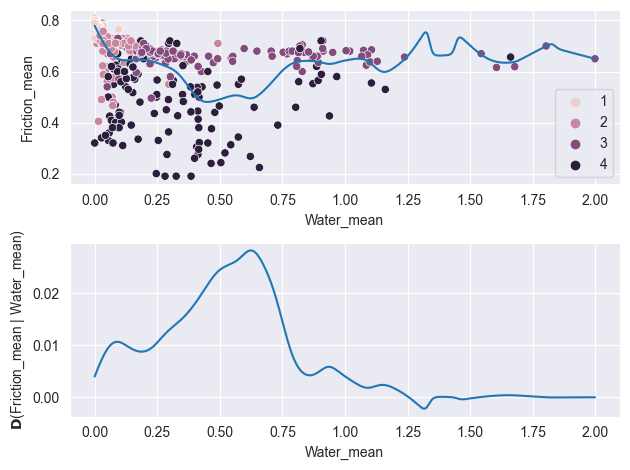

In [46]:
conditional_exp_var(samplel4, 'Water_mean', 'Friction_mean')

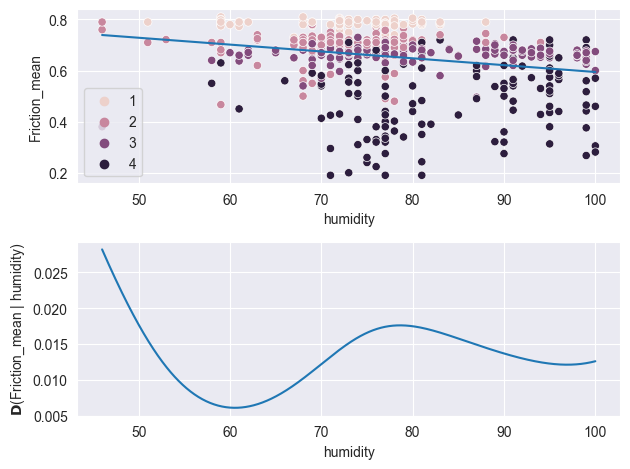

In [47]:
conditional_exp_var(samplel4, 'humidity', 'Friction_mean')

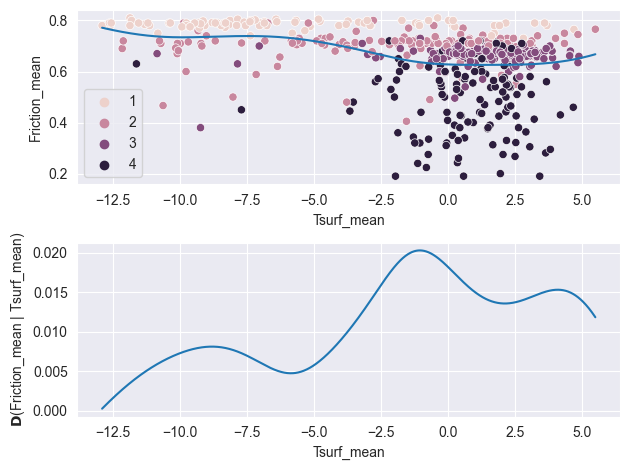

In [48]:
conditional_exp_var(samplel4, 'Tsurf_mean', 'Friction_mean')